In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def diff_sigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [4]:

import pandas as pd
df = pd.read_csv('Bias_correction_ucl.csv', usecols=['station','Date','Present_Tmax', 'Next_Tmax'])

dateslist =[]
first_station = df.iloc[0]['station']
for row in df.itertuples(index=True, name='Pandas'):
    if getattr(row, "station") == first_station:
        dateslist.append(getattr(row, "Present_Tmax") )
for station in range(25):
    first_station = df.iloc[station]['station']
    for row in df.itertuples(index=True, name='Pandas'):
        if getattr(row, "station") == first_station:
            dateslist.append(getattr(row, "Present_Tmax") )


In [5]:

all_temp = np.array(dateslist).reshape(-1, 1)
all_temp = all_temp[~np.isnan(all_temp)].reshape(-1, 1)
all_temp = all_temp.astype(float)

In [6]:

N = 30  # number of input data
all_rows = len(all_temp) - N - 5 + 1

Temp_N_batch = np.zeros((all_rows, N))
Temp_label = np.zeros((all_rows, 1))

for i in range(all_rows):
    Temp_N_batch[i] = all_temp[i: N + i, 0]
    Temp_label[i] = all_temp[N + i + 5 - 1, 0]



In [7]:


# ---------------------> Normalizing Data
max_temp = max(all_temp)
min_temp = min(all_temp)

Temp_N_batch_norm = (Temp_N_batch - min_temp) / (max_temp - min_temp)
Temp_label_norm = (Temp_label - min_temp) / (max_temp - min_temp)


# --------------------->Separating Train, Validation & Test Data
index = np.linspace(0, all_rows - 1, all_rows)  # 0 to all_rows

index_train = np.sort(random.sample(list(index), k=int(0.7 * all_rows)))                  # 70% of Data for Training

index = np.delete(index, list(map(int, index_train)))
index_valid = np.sort(random.sample(list(index), k=int(0.15 * all_rows)))                 # 15% of Data for Validation

index_test = np.array(list(set(index).difference(index_valid)))                           # 15% of Data for Test


Train_input = Temp_N_batch_norm[list(index_train.astype(int))]
Train_output = Temp_label_norm[list(index_train.astype(int))]

Valid_input = Temp_N_batch_norm[list(index_valid.astype(int))]
Valid_output = Temp_label_norm[list(index_valid.astype(int))]

Test_input = Temp_N_batch_norm[list(index_test.astype(int))]
Test_output = Temp_label_norm[list(index_test.astype(int))]

In [8]:


#                                             Auto-Encoder Initialization
########################################################################################################################
l0_neurons = N
l1_neurons = 85
l2_neurons = 38
l3_neurons = 15
train_rate=0.7
eta_e1 = 0.01
eta_e2 = 0.02
eta_e3 = 0.03
eta_p = 0.01
epochs_ae = 30
max_epoch_p = 60
lowerb=-0.2;
upperb=0.2;
# layer 1
w_e1 = np.random.uniform(low=lowerb, high=upperb, size=(N, l1_neurons))
w_d1 = np.random.uniform(low=lowerb, high= upperb, size=(l1_neurons, N))


# layer 2
w_e2 = np.random.uniform(low=lowerb, high=upperb, size=(l1_neurons, l2_neurons))
w_d2 = np.random.uniform(low=lowerb, high=upperb, size=(l2_neurons, l1_neurons))


# layer 3
w_e3 = np.random.uniform(low=lowerb, high=upperb, size=(l2_neurons, l3_neurons))
w_d3 = np.random.uniform(low=lowerb, high=upperb, size=(l3_neurons, l2_neurons))


In [9]:

# Learning Rate
a = eta_e1

epochs =120

MSE_train = []
MSE_valid = []
MSE_test = []

Train_predict = np.zeros((len(index_train), N))
Valid_predict = np.zeros((len(index_valid), N))
Test_predict = np.zeros((len(index_test), N))

sqr_error_train = np.zeros((len(index_train), N))
sqr_error_valid = np.zeros((len(index_valid), N))
sqr_error_test = np.zeros((len(index_test), N))


In [10]:

#                                            Training Auto-Encoder (first layer)
########################################################################################################################

print('\n--------------------------------Training first layer of Auto-Encoder-------------------------------------\n')
for epoch in range(epochs):

    for i in range(len(index_train)):  # iteration for training data
        #encoder 1
        net_e1 = np.matmul(Train_input[i], w_e1)
        h_1 = sigmoid(net_e1).reshape(1, -1)
        #decoder 1
        net_d1 = np.matmul(h_1, w_d1)
        x_hat = sigmoid(net_d1).reshape(1, -1)

        Train_predict[i] = x_hat

        # Error
        err = Train_predict[i] - Train_input[i]
        sqr_error_train[i] = err ** 2

        # Back propagation

        G1 = a * np.reshape(err, (1, N)) * diff_sigmoid(net_d1)
        G2 = a * np.reshape(err, (1, N)) * diff_sigmoid(net_d1)
        G3 = diff_sigmoid(net_e1).reshape(1, -1)
        G4 = diff_sigmoid(net_e1).reshape(1, -1)

        w_e1 = w_e1 - np.matmul(np.transpose(G2 * Train_input[i]), G4) * np.transpose(w_d1)
        w_d1 = w_d1 - np.transpose(h_1) * G2

    MSE_train.append(0.5 * np.sum(sqr_error_train) / len(sqr_error_train))

    # --------------------------------------------- Calculating Error --------------------------------------------------

    for i in range(len(index_valid)):  # Calculating Error of Validation data

        # Valid Prediction
        net_e1 = np.matmul(Valid_input[i], w_e1)
        h_1 = sigmoid(net_e1)

        net_d1 = np.matmul(h_1, w_d1)
        x_hat = sigmoid(net_d1)

        Valid_predict[i] = x_hat

        # Error valid
        err_valid = Valid_predict[i] - Valid_input[i]
        sqr_error_valid[i] = err_valid ** 2

    MSE_valid.append(0.5 * np.sum(sqr_error_valid) / len(sqr_error_valid))

    # Printing Error
    print('Epoch %i ==> Error Train: %.3f      Error Validation: %.4f' % (
    epoch + 1, 0.5 * np.sum(sqr_error_train) / len(sqr_error_train), MSE_valid[-1]))

for i in range(len(index_test)):  # Calculating Error of Test data

    # Test Prediction
    net_e1 = np.matmul(Test_input[i], w_e1)
    h_1 = sigmoid(net_e1)

    net_d1 = np.matmul(h_1, w_d1)
    x_hat = sigmoid(net_d1)

    Test_predict[i] = x_hat

    # Error test
    err_test = Test_predict[i] - Test_input[i]
    sqr_error_test[i] = err_test ** 2

MSE_test.append(0.5 * np.sum(sqr_error_test) / len(sqr_error_test))
print('\nError of Test Data: %.3f\n' % MSE_test[0])




--------------------------------Training first layer of Auto-Encoder-------------------------------------

Epoch 1 ==> Error Train: 0.397      Error Validation: 0.4782
Epoch 2 ==> Error Train: 0.382      Error Validation: 0.4553
Epoch 3 ==> Error Train: 0.365      Error Validation: 0.4302
Epoch 4 ==> Error Train: 0.347      Error Validation: 0.4025
Epoch 5 ==> Error Train: 0.328      Error Validation: 0.3725
Epoch 6 ==> Error Train: 0.308      Error Validation: 0.3417
Epoch 7 ==> Error Train: 0.287      Error Validation: 0.3116
Epoch 8 ==> Error Train: 0.267      Error Validation: 0.2839
Epoch 9 ==> Error Train: 0.249      Error Validation: 0.2595
Epoch 10 ==> Error Train: 0.232      Error Validation: 0.2389
Epoch 11 ==> Error Train: 0.218      Error Validation: 0.2220
Epoch 12 ==> Error Train: 0.206      Error Validation: 0.2082
Epoch 13 ==> Error Train: 0.195      Error Validation: 0.1970
Epoch 14 ==> Error Train: 0.187      Error Validation: 0.1877
Epoch 15 ==> Error Train: 0.179  

In [11]:


#                                         Training Auto-Encoder (second layer)
########################################################################################################################

# ------------------------------------------------- Initialization -----------------------------------------------------

MSE_train = []
MSE_valid = []
MSE_test = []

del G1, G2, G3, G4

# Learning Rate
a = eta_e2

epochs = 60

Train_predict = np.zeros((len(index_train), l1_neurons))
Valid_predict = np.zeros((len(index_valid), l1_neurons))
Test_predict = np.zeros((len(index_test), l1_neurons))

Train_encoder2 = np.zeros((len(index_train), l1_neurons))
Valid_encoder2 = np.zeros((len(index_valid), l1_neurons))

sqr_error_train = np.zeros((len(index_train), l1_neurons))
sqr_error_valid = np.zeros((len(index_valid), l1_neurons))
sqr_error_test = np.zeros((len(index_test), l1_neurons))

# --------------------------------------------------- Training ---------------------------------------------------------

print('--------------------------------Training second layer of Auto-Encoder------------------------------------\n')
for epoch in range(epochs):

    for i in range(len(index_train)):  # iteration for training data

        # input from Layer 1
        net_e1 = np.matmul(Train_input[i], w_e1)
        h_1 = sigmoid(net_e1).reshape(1, -1)

        # Layer 2
        net_e2 = np.matmul(h_1, w_e2)
        h_2 = sigmoid(net_e2).reshape(1, -1)

        net_d2 = np.matmul(h_2, w_d2)
        h1_hat = sigmoid(net_d2).reshape(1, -1)

        Train_predict[i] = h1_hat
        Train_encoder2[i] = h_1

        # Error
        err = h1_hat - h_1
        sqr_error_train[i] = err ** 2

        # Back propagation

        G1 = a * np.reshape(err, (1, l1_neurons)) * diff_sigmoid(net_d2)
        G2 = a * np.reshape(err, (1, l1_neurons)) * diff_sigmoid(net_d2)
        G3 = diff_sigmoid(net_e2)
        G4 = diff_sigmoid(net_e2).reshape(1, -1)

        w_e2 = w_e2 - np.matmul(np.transpose(G2 * h_1), G4) * np.transpose(w_d2)
        w_d2 = w_d2 - np.transpose(h_2) * G2



    # Saving Error
    MSE_train.append(0.5 * np.sum(sqr_error_train) / len(sqr_error_train))

    # --------------------------------------------- Calculating Error --------------------------------------------------

    for i in range(len(index_valid)):  # Calculating Error of Validation data

        # input
        net_e1 = np.matmul(Valid_input[i], w_e1)
        h_1 = sigmoid(net_e1)

        # Layer 2
        net_e2 = np.matmul(h_1, w_e2)
        h_2 = sigmoid(net_e2)

        net_d2 = np.matmul(h_2, w_d2)
        h1_hat = sigmoid(net_d2)

        Valid_predict[i] = h1_hat
        Valid_encoder2[i] = h_1

        # Error valid
        err_valid = h1_hat - h_1
        sqr_error_valid[i] = err_valid ** 2

    MSE_valid.append(0.5 * np.sum(sqr_error_valid) / len(sqr_error_valid))

    # Printing Error
    print('Epoch %i ==> Error Train: %.3f        Error Validation: %.4f' % (
    epoch + 1, 0.5 * np.sum(sqr_error_train) / len(sqr_error_train), MSE_valid[-1]))

for i in range(len(index_test)):  # Calculating Error of Test data

    # input
    net_e1 = np.matmul(Test_input[i], w_e1)
    h_1 = sigmoid(net_e1)

    # Layer 2
    net_e2 = np.matmul(h_1, w_e2)
    h_2 = sigmoid(net_e2)

    net_d2 = np.matmul(h_2, w_d2)
    h1_hat = sigmoid(net_d2)

    Test_predict[i] = h1_hat

    # Error test
    err_test = h1_hat - h_1
    sqr_error_test[i] = err_test ** 2

MSE_test.append(0.5 * np.sum(sqr_error_test) / len(sqr_error_test))
print('\nError of Test Data: %.3f\n' % MSE_test[0])



--------------------------------Training second layer of Auto-Encoder------------------------------------

Epoch 1 ==> Error Train: 0.451        Error Validation: 0.4063
Epoch 2 ==> Error Train: 0.389        Error Validation: 0.3885
Epoch 3 ==> Error Train: 0.368        Error Validation: 0.3616
Epoch 4 ==> Error Train: 0.336        Error Validation: 0.3264
Epoch 5 ==> Error Train: 0.301        Error Validation: 0.2907
Epoch 6 ==> Error Train: 0.268        Error Validation: 0.2607
Epoch 7 ==> Error Train: 0.242        Error Validation: 0.2369
Epoch 8 ==> Error Train: 0.221        Error Validation: 0.2175
Epoch 9 ==> Error Train: 0.203        Error Validation: 0.2010
Epoch 10 ==> Error Train: 0.188        Error Validation: 0.1863
Epoch 11 ==> Error Train: 0.174        Error Validation: 0.1733
Epoch 12 ==> Error Train: 0.162        Error Validation: 0.1619
Epoch 13 ==> Error Train: 0.152        Error Validation: 0.1520
Epoch 14 ==> Error Train: 0.142        Error Validation: 0.1435
Epoch 

In [12]:


#                                         Training Auto-Encoder (Third layer)
########################################################################################################################

# ------------------------------------------------- Initialization -----------------------------------------------------

MSE_train = []
MSE_valid = []
MSE_test = []

del G1, G2, G3, G4

# Learning Rate
a = eta_e3

epochs = 120

Train_predict = np.zeros((len(index_train), l2_neurons))
Valid_predict = np.zeros((len(index_valid), l2_neurons))
Test_predict = np.zeros((len(index_test), l2_neurons))

Train_encoder3 = np.zeros((len(index_train), l2_neurons))
Valid_encoder3 = np.zeros((len(index_valid), l2_neurons))

sqr_error_train = np.zeros((len(index_train), l2_neurons))
sqr_error_valid = np.zeros((len(index_valid), l2_neurons))
sqr_error_test = np.zeros((len(index_test), l2_neurons))

# --------------------------------------------------- Training ---------------------------------------------------------

print('--------------------------------Training third layer of Auto-Encoder-------------------------------------\n')
for epoch in range(epochs):

    for i in range(len(index_train)):  # iteration for training data

        # input from Layer 1
        net_e1 = np.matmul(Train_input[i], w_e1)
        h_1 = sigmoid(net_e1).reshape(1, -1)

        # input from Layer 2
        net_e2 = np.matmul(h_1, w_e2)
        h_2 = sigmoid(net_e2).reshape(1, -1)

        net_e3 = np.matmul(h_2, w_e3)
        h_3 = sigmoid(net_e3).reshape(1, -1)

        net_d3 = np.matmul(h_3, w_d3)
        h2_hat = sigmoid(net_d3).reshape(1, -1)

        Train_predict[i] = h2_hat
        Train_encoder3[i] = h_2

        # Error
        err = h2_hat - h_2
        sqr_error_train[i] = err ** 2

        # Back propagation
        G1 = a * np.reshape(err, (1, l2_neurons)) * diff_sigmoid(net_d3)
        G2 = a * np.reshape(err, (1, l2_neurons)) * diff_sigmoid(net_d3)
        G3 = diff_sigmoid(net_e3).reshape(1, -1)
        G4 = diff_sigmoid(net_e3).reshape(1, -1)

        w_e3 = w_e3 - np.matmul(np.transpose(G2 * h_2), G4) * np.transpose(w_d3)
        w_d3 = w_d3 - np.transpose(h_3) * G2



    # Saving Error
    MSE_train.append(0.5 * np.sum(sqr_error_train) / len(sqr_error_train))

    # --------------------------------------------- Calculating Error --------------------------------------------------

    for i in range(len(index_valid)):  # Calculating Error of Validation data

        # input from Layer 1
        net_e1 = np.matmul(Valid_input[i], w_e1)
        h_1 = sigmoid(net_e1).reshape(1, -1)

        # input from Layer 2
        net_e2 = np.matmul(h_1, w_e2)
        h_2 = sigmoid(net_e2).reshape(1, -1)

        net_e3 = np.matmul(h_2, w_e3)
        h_3 = sigmoid(net_e3).reshape(1, -1)

        net_d3 = np.matmul(h_3, w_d3)
        h2_hat = sigmoid(net_d3).reshape(1, -1)

        Valid_predict[i] = h2_hat
        Valid_encoder3[i] = h_2

        # Error valid
        err_valid = h2_hat - h_2
        sqr_error_valid[i] = err_valid ** 2

    MSE_valid.append(0.5 * np.sum(sqr_error_valid) / len(sqr_error_valid))

    # Printing Error
    print('Epoch %i ==> Error Train: %.3f     Error Validation: %.4f' % (
    epoch + 1, 0.5 * np.sum(sqr_error_train) / len(sqr_error_train), MSE_valid[-1]))

for i in range(len(index_test)):  # Calculating Error of Test data

    # input from Layer 1
    net_e1 = np.matmul(Test_input[i], w_e1)
    h_1 = sigmoid(net_e1)

    # input from Layer 2
    net_e2 = np.matmul(h_1, w_e2)
    h_2 = sigmoid(net_e2)

    net_e3 = np.matmul(h_2, w_e3)
    h_3 = sigmoid(net_e3)

    net_d3 = np.matmul(h_3, w_d3)
    h2_hat = sigmoid(net_d3)

    Test_predict[i] = h2_hat

    # Error test
    err_test = h2_hat - h_2
    sqr_error_test[i] = err_test ** 2

MSE_test.append(0.5 * np.sum(sqr_error_test) / len(sqr_error_test))
print('\nError of Test Data: %.3f\n' % MSE_test[0])


--------------------------------Training third layer of Auto-Encoder-------------------------------------

Epoch 1 ==> Error Train: 0.497     Error Validation: 0.4650
Epoch 2 ==> Error Train: 0.400     Error Validation: 0.3531
Epoch 3 ==> Error Train: 0.306     Error Validation: 0.2872
Epoch 4 ==> Error Train: 0.256     Error Validation: 0.2399
Epoch 5 ==> Error Train: 0.214     Error Validation: 0.1997
Epoch 6 ==> Error Train: 0.181     Error Validation: 0.1710
Epoch 7 ==> Error Train: 0.157     Error Validation: 0.1505
Epoch 8 ==> Error Train: 0.140     Error Validation: 0.1349
Epoch 9 ==> Error Train: 0.126     Error Validation: 0.1225
Epoch 10 ==> Error Train: 0.115     Error Validation: 0.1125
Epoch 11 ==> Error Train: 0.106     Error Validation: 0.1044
Epoch 12 ==> Error Train: 0.099     Error Validation: 0.0979
Epoch 13 ==> Error Train: 0.093     Error Validation: 0.0928
Epoch 14 ==> Error Train: 0.089     Error Validation: 0.0886
Epoch 15 ==> Error Train: 0.085     Error Valida

In [13]:

#                                                     MLP - 2 Layers
########################################################################################################################

# --------------------------------------------------- Initialization ---------------------------------------------------

l4_neurons = 5
l5_neurons = 1

w_1 = np.random.uniform(low=-0.1, high=0.1, size=(l3_neurons, l4_neurons))
w_2 = np.random.uniform(low=-0.1, high=0.1, size=(l4_neurons, l5_neurons))


a = 0.03  # Learning Rate
epochs = 60

MSE_train = []
MSE_valid = []
MSE_test = []

Train_predict = np.zeros((len(index_train), 1))
Valid_predict = np.zeros((len(index_valid), 1))
Test_predict = np.zeros((len(index_test), 1))

sqr_error_train = np.zeros((len(index_train), 1))
sqr_error_valid = np.zeros((len(index_valid), 1))
sqr_error_test = np.zeros((len(index_test), 1))

#  -------------------------------------------------- Training Network -------------------------------------------------


print('--------------------------Training MLP (weights of Auto-Encoder are frozen)----------------------------------\n')
for epoch in range(epochs):

    for i in range(len(index_train)):  # iteration for training data

        # Auto-Encoder
        net_e1 = np.matmul(Train_input[i], w_e1)
        h_1 = sigmoid(net_e1)

        net_e2 = np.matmul(h_1, w_e2)
        h_2 = sigmoid(net_e2)

        net_e3 = np.matmul(h_2, w_e3)
        h_3 = sigmoid(net_e3).reshape(1, -1)

        # MLP
        net_1 = np.matmul(h_3, w_1)
        o_1 = sigmoid(net_1)

        net_2 = np.matmul(o_1, w_2)
        o_2 = sigmoid(net_2)

        Train_predict[i] = o_2

        # Error
        err = Train_predict[i] - Train_output[i]
        sqr_error_train[i] = err ** 2

        # Back propagation
        w_1 = w_1 - a * err * diff_sigmoid(net_2) * np.matmul(np.transpose(h_3).reshape(l3_neurons, 1),
                                                              diff_sigmoid(net_1) * np.transpose(w_2))
        w_2 = w_2 - a * err * diff_sigmoid(net_2) * np.transpose(o_1)



    # Saving Error
    MSE_train.append(0.5 * np.sum(sqr_error_train) / len(sqr_error_train))

    # --------------------------------------------- Calculating Error --------------------------------------------------

    for i in range(len(index_valid)):  # Calculating Error of Validation data

        # Auto-Encoder
        net_e1 = np.matmul(Valid_input[i], w_e1)
        h_1 = sigmoid(net_e1)

        net_e2 = np.matmul(h_1, w_e2)
        h_2 = sigmoid(net_e2)

        net_e3 = np.matmul(h_2, w_e3)
        h_3 = sigmoid(net_e3).reshape(1, -1)

        # MLP
        net_1 = np.matmul(h_3, w_1)
        o_1 = sigmoid(net_1)

        net_2 = np.matmul(o_1, w_2)
        o_2 = sigmoid(net_2)

        Valid_predict[i] = o_2

        # Error valid
        err_valid = Valid_predict[i] - Valid_output[i]
        sqr_error_valid[i] = err_valid ** 2

    MSE_valid.append(0.5 * np.sum(sqr_error_valid) / len(sqr_error_valid))
    print('Epoch %i ==> Error Train: %0.4f       Error Validation: %0.4f' % (
    epoch, 0.5 * np.sum(sqr_error_train) / len(sqr_error_train), MSE_valid[-1]))

for i in range(len(index_test)):  # Calculating Error of Test data

    # Auto-Encoder
    net_e1 = np.matmul(Test_input[i], w_e1)
    h_1 = sigmoid(net_e1)

    net_e2 = np.matmul(h_1, w_e2)
    h_2 = sigmoid(net_e2)

    net_e3 = np.matmul(h_2, w_e3)
    h_3 = sigmoid(net_e3).reshape(1, -1)

    # MLP
    net_1 = np.matmul(h_3, w_1)
    o_1 = sigmoid(net_1)

    net_2 = np.matmul(o_1, w_2)
    o_2 = sigmoid(net_2)

    Test_predict[i] = o_2

    # Error test
    err_test = Test_predict[i] - Test_output[i]
    sqr_error_test[i] = err_test ** 2

MSE_test.append(0.5 * np.sum(sqr_error_test) / len(sqr_error_test))
print('\nError of Test Data: %.4f\n' % MSE_test[0])

--------------------------Training MLP (weights of Auto-Encoder are frozen)----------------------------------

Epoch 0 ==> Error Train: 0.0142       Error Validation: 0.0156
Epoch 1 ==> Error Train: 0.0144       Error Validation: 0.0156
Epoch 2 ==> Error Train: 0.0144       Error Validation: 0.0156
Epoch 3 ==> Error Train: 0.0144       Error Validation: 0.0156
Epoch 4 ==> Error Train: 0.0143       Error Validation: 0.0155
Epoch 5 ==> Error Train: 0.0143       Error Validation: 0.0155
Epoch 6 ==> Error Train: 0.0143       Error Validation: 0.0155
Epoch 7 ==> Error Train: 0.0143       Error Validation: 0.0154
Epoch 8 ==> Error Train: 0.0142       Error Validation: 0.0154
Epoch 9 ==> Error Train: 0.0142       Error Validation: 0.0153
Epoch 10 ==> Error Train: 0.0141       Error Validation: 0.0153
Epoch 11 ==> Error Train: 0.0141       Error Validation: 0.0152
Epoch 12 ==> Error Train: 0.0140       Error Validation: 0.0151
Epoch 13 ==> Error Train: 0.0139       Error Validation: 0.0150
Epo

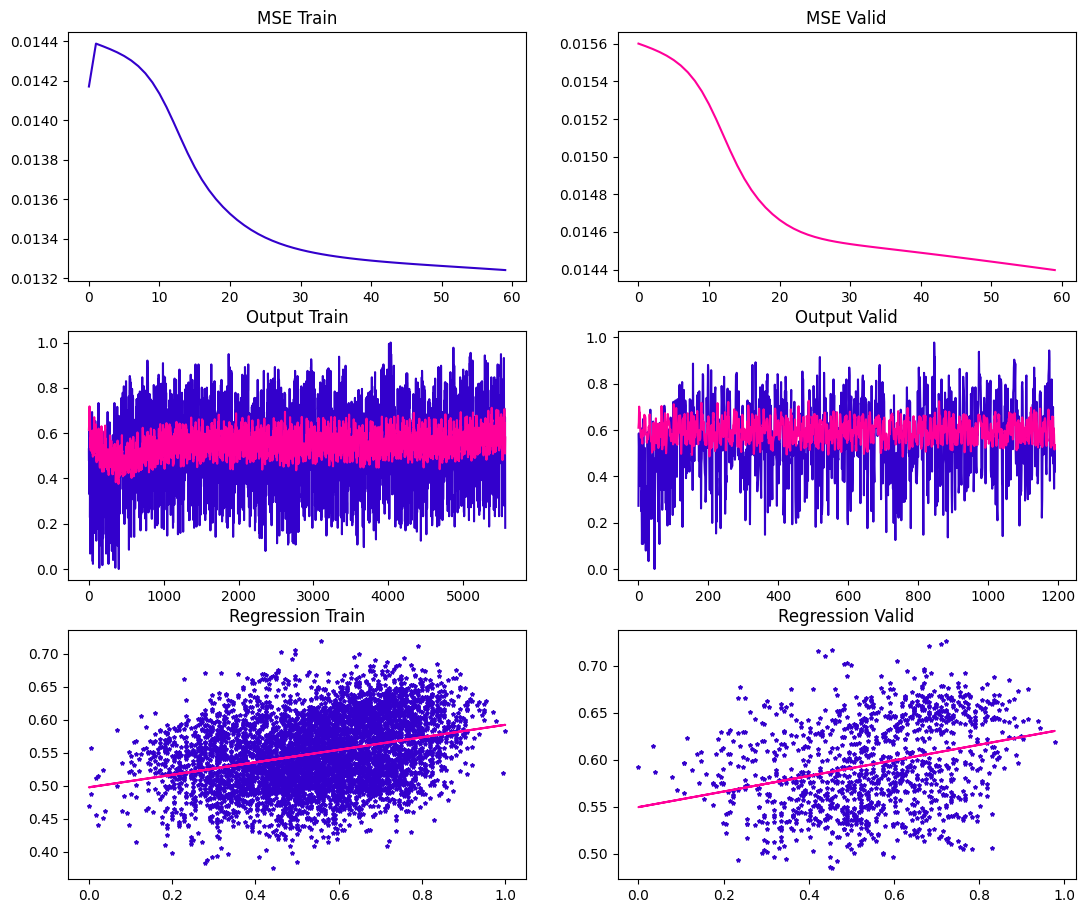

In [14]:

# ---------------------------------------------------- Plotting --------------------------------------------------------

# Ploy fits

# Train
m_train, b_train = np.polyfit(Train_output.reshape(len(index_train), ), Train_predict.reshape(len(index_train), ), 1)

# Valid
m_test, b_test = np.polyfit(Valid_output.reshape(len(index_valid), ), Valid_predict.reshape(len(index_valid), ), 1)

# Plots
fig, axs = plt.subplots(3, 2, figsize=(13, 11))
axs[0, 0].plot(MSE_train, '#3300CC')
axs[0, 0].set_title('MSE Train')
axs[0, 1].plot(MSE_valid, '#FF0099')
axs[0, 1].set_title('MSE Valid')

axs[1, 0].plot(Train_output, '#3300CC')
axs[1, 0].plot(Train_predict, '#FF0099')
axs[1, 0].set_title('Output Train')
axs[1, 1].plot(Valid_output, '#3300CC')
axs[1, 1].plot(Valid_predict, '#FF0099')
axs[1, 1].set_title('Output Valid')

axs[2, 0].plot(Train_output, Train_predict, color='#3300CC', marker='*', linestyle='None', markersize=3)
axs[2, 0].plot(Train_output, m_train * Train_output + b_train, '#FF0099')
axs[2, 0].set_title('Regression Train')
axs[2, 1].plot(Valid_output, Valid_predict, color='#3300CC', marker='*', linestyle='None', markersize=3)
axs[2, 1].plot(Valid_output, m_test * Valid_output + b_test, '#FF0099')
axs[2, 1].set_title('Regression Valid')

# plt.savefig('Results-of-AutoEncoder-MLP-localTraining.png', dpi=800)
plt.show()